## 1. Introduction — do all the preprocessing from the previous lesson.

### 1. Import.

In [268]:
import shap, time, optuna
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import uniform
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, TimeSeriesSplit

In [269]:
df = pd.read_json('./data/train.json')
df['created'] = pd.to_datetime(df['created'])

### 2. Clean data and remove the lines outside the 1st and 99th percentiles.

In [270]:
percentile_1 = np.percentile(df['price'], 1)
percentile_99 = np.percentile(df['price'], 99)
df = df.loc[(percentile_1 < df['price']) & (df['price'] < percentile_99)]

### 3. Remove unused symbols ([, ], ', ", and space) from 'features' column.

In [271]:
def remove_symbols(feature):
    for s in '[]\'" ':
        feature = feature.replace(s, '')
    return feature

df['features'] = df['features'].apply(lambda features: [remove_symbols(feature) for feature in features])

### 4. Create 20 new features.

In [272]:
features = ['Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed',
            'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding',
            'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck',
            'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony',
            'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace']

In [273]:
df = df[['created', 'building_id', 'bathrooms', 'bedrooms', 'features', 'price']]
for feature in features:
    df[feature] = df['features'].apply(lambda features: int(feature in features))
df = df.drop(columns=['features'])
X_with_time = df.drop(columns=['price', 'building_id'])
X_with_id = df.drop(columns=['price', 'created'])
X = df.drop(columns=['price', 'created', 'building_id'])
y = df['price']

## 2. Implement DataSplitter.

In [274]:
class DataSplitter():
    def __init__(self, random_state=None):
        self._rng = np.random.default_rng(seed=random_state)

    def train_test_split(self, X, y, test_size):
        size = X.shape[0]
        indexes = np.arange(size)
        self._rng.shuffle(indexes)

        split = int(size * (1 - test_size))

        train_indexes = indexes[:split]
        test_indexes = indexes[split:]
        
        X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
        X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]
        return X_train, X_test, y_train, y_test
    
    def train_valid_test_split(self, X, y, validation_size, test_size):        
        size = X.shape[0]
        indexes = np.arange(size)
        self._rng.shuffle(indexes)

        split_valid = int(size * (1 - test_size - validation_size))
        split_test = int(size * (1 - test_size))

        train_indexes = indexes[:split_valid]
        valid_indexes = indexes[split_valid : split_test]
        test_indexes = indexes[split_test:]

        X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
        X_valid, y_valid = X.iloc[valid_indexes], y.iloc[valid_indexes]
        X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    
    def time_train_test_split(self, X, y, date_split):
        if date_split > X['created'].max() or date_split < X['created'].min():
            raise ValueError('Invalid date_split value')
        X_train = X[X['created'] < date_split]
        X_test = X[X['created'] >= date_split]
        y_train, y_test = y.loc[X_train.index], y.loc[X_test.index]
        return X_train, X_test, y_train, y_test
    
    def time_train_valid_test_split(self, X, y, validation_date, test_date):
        if test_date > X['created'].max():
            raise ValueError('Invalid test_date value')
        if validation_date > test_date or validation_date < X['created'].min():
            raise ValueError('Invalid validation_date value')
        X_train = X[X['created'] < validation_date]
        X_valid = X[(validation_date <= X['created']) & (X['created'] < test_date)]
        X_test = X[X['created'] >= test_date]
        y_train, y_valid, y_test = y.loc[X_train.index], y.loc[X_valid.index], y.loc[X_test.index]
        return X_train, X_valid, X_test, y_train, y_valid, y_test


## 3. Implement the cross-validation methods.

### 1. Implementation K-Fold.

In [275]:
class CustomKFold():
    def __init__(self, k):
        self._k = k

    def split(self, X):
        indexes = X.index
        split_indexes = np.array_split(indexes, indices_or_sections=self._k)
        for i in range(self._k):
            test_index = split_indexes[i]
            train_index = np.concatenate(split_indexes[:i] + split_indexes[i+1:])
            yield train_index, test_index

### 2. Implementation Grouped K-Fold.

In [276]:
class CustomGroupKFold():
    def __init__(self, k):
        self._k = k

    def split(self, X, group_field):
        group_column = X[group_field]        
        group_rows = group_column.value_counts()
        if self._k > len(group_rows):
            raise ValueError('Number of splits greater than the number of groups')

        split_rows = group_rows.to_list()[:self._k]
        split_groups = [[group] for group in group_rows.iloc[:self._k].index]
        for group, rows in group_rows.iloc[self._k:].items():
            min_index = np.argmin(split_rows)
            split_rows[min_index] += rows
            split_groups[min_index].append(group)

        for i in range(self._k):
            test_group = split_groups[i]
            test_index = list(group_column[group_column.isin(test_group)].index)
            train_index = np.setdiff1d(group_column.index, test_index)
            yield train_index, test_index

### 3. Implementation Stratified K-fold.

In [277]:
class CustomStratifiedKFold():
    def __init__(self, k):
        self._k = k

    def split(self, X, stratify_field):
        stratify_column = X[stratify_field]
        group_indexes = stratify_column.groupby(stratify_column).groups
        for group, indexes in group_indexes.items():
            if self._k > len(indexes):
                raise ValueError(f"Number of splits greater than the length of '{group}' group")
            group_indexes[group] = np.array_split(indexes, indices_or_sections=self._k)

        for i in range(self._k):
            test_index = np.concatenate([indexes[i] for indexes in group_indexes.values()])
            train_index = np.concatenate([np.concatenate(indexes[:i] + indexes[i+1:]) for indexes in group_indexes.values()])
            yield train_index, test_index

### 4. Implementation Time series split.

In [278]:
class CustomTimeSeriesSplit():
    def __init__(self, k):
        self._k = k + 1

    def split(self, X, date_field):
        X = X.sort_values(by=date_field)
        indexes = X.index
        split_indexes = np.array_split(indexes, indices_or_sections=self._k)
        for i in range(1, self._k):
            train_index = np.concatenate(split_indexes[:i])
            test_index = list(split_indexes[i])
            yield train_index, test_index

## 4. Cross-validation comparison.

Average Relative Difference across folds (%)

$$
rel_{diff} = 100 \times \frac{|mean_{original} - mean_{method}|}{|mean_{original}|}
$$

$$
avg\_rel_{diff} = \frac{1}{N}\sum_{i=1}^{N} rel_{diff}^{(i)}
$$

In [279]:
result_target_table = pd.DataFrame(columns=np.concat([X.describe().index, ['median']]))
result_feature_table = pd.DataFrame(columns=X.columns)
mean_original = X.mean()

def add_target_distribution(selector_name, y_train):
    describe = y_train.describe()
    describe['median'] = y_train.median()
    result_target_table.loc[selector_name] = describe

def add_feature_distribution(selector_name, X_avg_rel_diff):
    result_feature_table.loc[selector_name] = X_avg_rel_diff

In [280]:
def calculate_train_distribution(selector, selector_name, *split_args, **split_kwargs):
    rel_diff = pd.DataFrame(columns=X.columns)

    for i, (train_index, test_index) in enumerate(selector.split(*split_args, **split_kwargs)):
        if selector_name.startswith('Sklearn'):
            add_target_distribution(f'{selector_name} fold-{i}', y.iloc[train_index])
            mean_fold = X.iloc[train_index].mean()
        else :
            add_target_distribution(f'{selector_name} fold-{i}', y[train_index])
            mean_fold = X.loc[train_index].mean()

        rel_diff.loc[i] = 100 * abs(mean_original - mean_fold) / abs(mean_original)

    X_avg_rel_diff = rel_diff.mean()
    add_feature_distribution(selector_name, X_avg_rel_diff)

### 1. K-Fold.

#### 1. CustomKFold.

In [281]:
ckf = CustomKFold(5)
calculate_train_distribution(ckf, 'CustomKFold', X)

#### 2. Sklearn KFold.

In [282]:
kf = KFold(5)
calculate_train_distribution(kf, 'Sklearn KFold', X)

#### 3. Results.

In [283]:
def plot_feature_distribution_comparison(start_with):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Feature Distribution Comparison', fontsize=20)
    for i, selector in enumerate(result_feature_table.index[start_with:]):
        ax[i].bar(x=result_feature_table.columns,
                height=result_feature_table.loc[selector].values,
                color=sns.color_palette('rocket_r', 22))
        ax[i].set_title(selector, fontsize=16)
        ax[i].set_ylabel('Average Relative Difference across folds (%)')
        ax[i].tick_params(axis='x', rotation=90)
    plt.show()

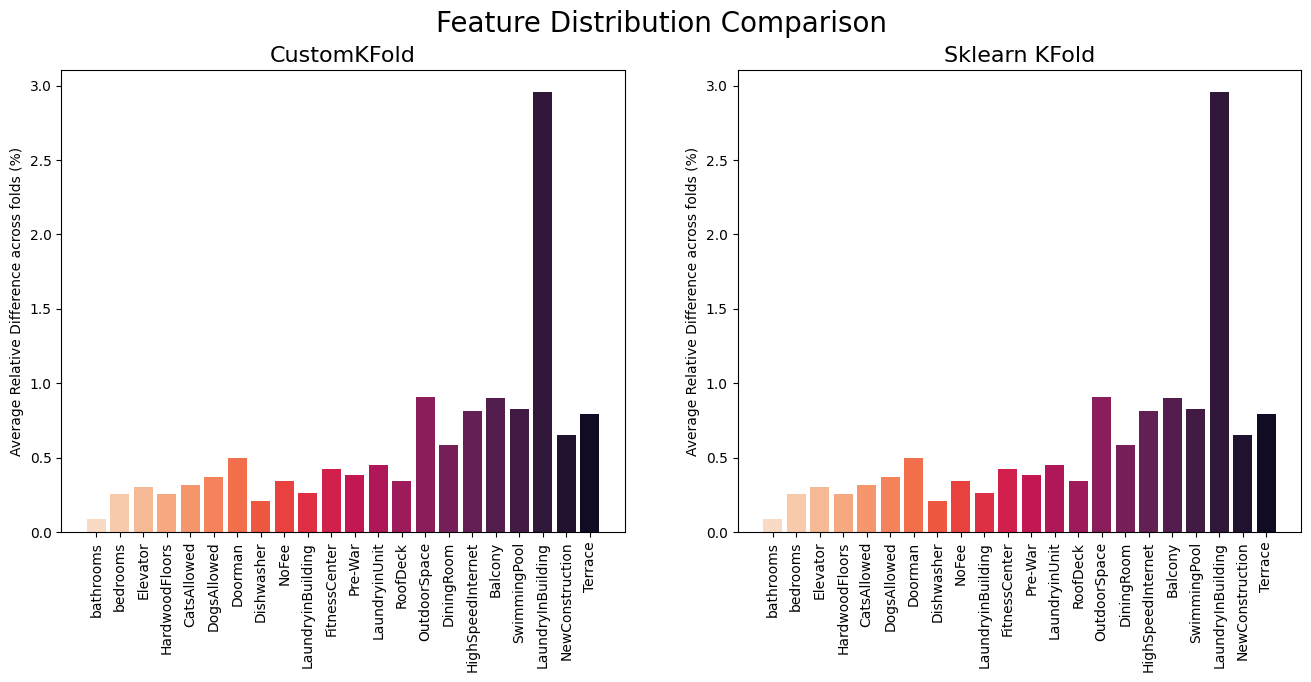

In [284]:
plot_feature_distribution_comparison(start_with=0)

In [285]:
result_target_table.round(2).tail(10)

,count,mean,std,min,25%,50%,75%,max,median
CustomKFold fold-0,38674.0,3533.63,1587.52,1485.0,2500.0,3150.0,4057.0,12995.0,3150.0
CustomKFold fold-1,38674.0,3529.38,1578.43,1485.0,2500.0,3150.0,4061.5,12995.0,3150.0
CustomKFold fold-2,38674.0,3528.69,1580.76,1495.0,2500.0,3150.0,4031.0,12995.0,3150.0
CustomKFold fold-3,38675.0,3540.32,1593.60,1485.0,2500.0,3150.0,4065.0,12995.0,3150.0
CustomKFold fold-4,38675.0,3543.82,1587.74,1485.0,2500.0,3160.0,4095.0,12995.0,3160.0
Sklearn KFold fold-0,38674.0,3533.63,1587.52,1485.0,2500.0,3150.0,4057.0,12995.0,3150.0
Sklearn KFold fold-1,38674.0,3529.38,1578.43,1485.0,2500.0,3150.0,4061.5,12995.0,3150.0
Sklearn KFold fold-2,38674.0,3528.69,1580.76,1495.0,2500.0,3150.0,4031.0,12995.0,3150.0
Sklearn KFold fold-3,38675.0,3540.32,1593.60,1485.0,2500.0,3150.0,4065.0,12995.0,3150.0
Sklearn KFold fold-4,38675.0,3543.82,1587.74,1485.0,2500.0,3160.0,4095.0,12995.0,3160.0


`Conclusion`: Реализация CustomKFold() работает аналогично KFold() из Sklearn.

### 2. Group K-Fold.

У нас есть признак `'building_id'` — id здания, в котором находится недвижимость. Группировка по нему может быть полезной, потому что квартиры в одном здании часто имеют похожие характеристики.

In [286]:
X_with_id['building_id'].value_counts()

building_id
0                                   8108
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     215
80a120d6bc3aba97f40fee8c2204524b     213
bb8658a3e432fb62a440615333376345     212
                                    ... 
8562df32eca55aeeed1a313570b7da0f       1
1ba204da9f08a06c526a05335dabcbd8       1
3e813705368e8d311e1dcdf2c9c5d94b       1
5902bb8c7f0ab5fccf66ad50cd482c8a       1
65236f52215952560b82accddace8e55       1
Name: count, Length: 7319, dtype: int64

#### 1. CustomGroupKFold.

In [287]:
cgkf = CustomGroupKFold(5)
calculate_train_distribution(cgkf, 'CustomGroupKFold', X_with_id, 'building_id')

#### 2. Sklearn GroupKFold.

In [288]:
gkf = GroupKFold(5)
calculate_train_distribution(gkf, 'Sklearn GroupKFold', X_with_id, groups=X_with_id['building_id'])

#### 3. Results.

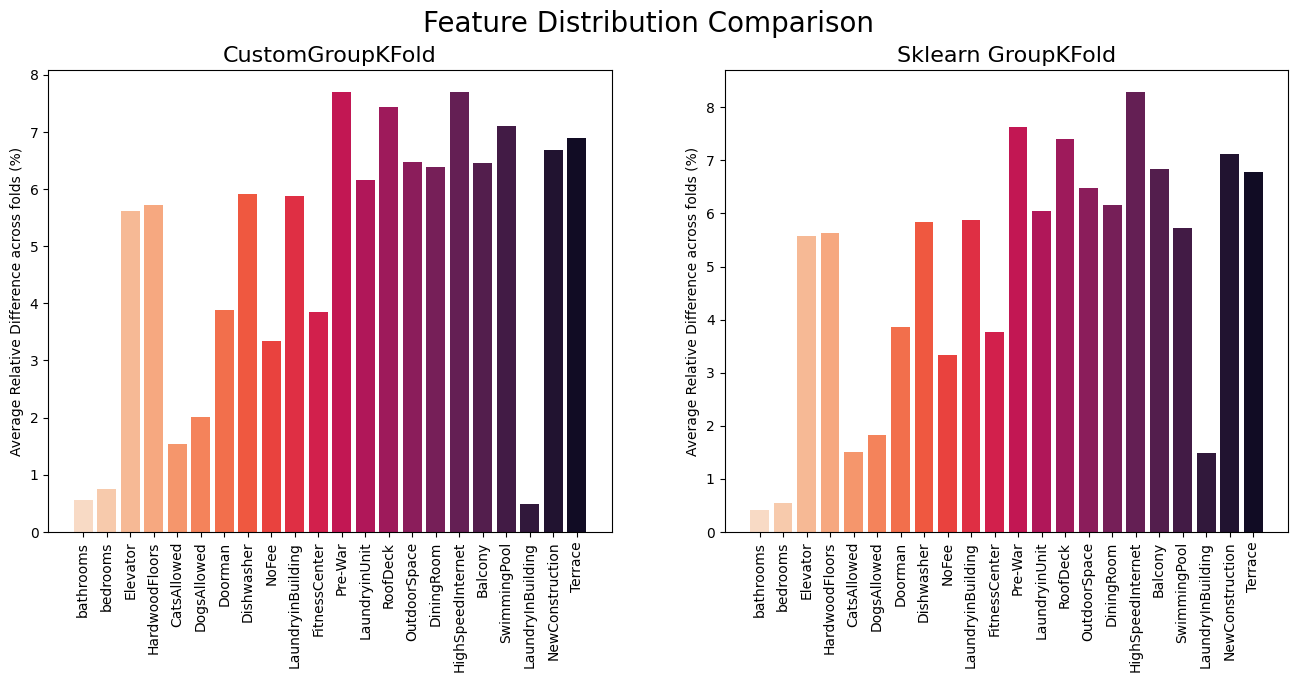

In [289]:
plot_feature_distribution_comparison(start_with=2)

In [290]:
result_target_table.round(2).tail(10)

,count,mean,std,min,25%,50%,75%,max,median
CustomGroupKFold fold-0,38674.0,3605.10,1596.94,1485.0,2550.0,3200.0,4200.0,12995.0,3200.0
CustomGroupKFold fold-1,38674.0,3501.51,1581.34,1485.0,2495.0,3100.0,4000.0,12995.0,3100.0
CustomGroupKFold fold-2,38674.0,3519.63,1557.52,1485.0,2500.0,3150.0,4020.0,12995.0,3150.0
CustomGroupKFold fold-3,38675.0,3512.10,1586.22,1485.0,2495.0,3100.0,4000.0,12995.0,3100.0
CustomGroupKFold fold-4,38675.0,3537.50,1603.58,1489.0,2500.0,3145.0,4095.0,12995.0,3145.0
Sklearn GroupKFold fold-0,38674.0,3603.29,1596.93,1485.0,2550.0,3200.0,4195.0,12995.0,3200.0
Sklearn GroupKFold fold-1,38674.0,3509.12,1583.56,1489.0,2495.0,3100.0,4000.0,12995.0,3100.0
Sklearn GroupKFold fold-2,38674.0,3512.93,1569.54,1485.0,2498.0,3100.0,4000.0,12995.0,3100.0
Sklearn GroupKFold fold-3,38675.0,3527.68,1597.86,1485.0,2500.0,3145.0,4025.0,12995.0,3145.0
Sklearn GroupKFold fold-4,38675.0,3522.82,1578.17,1485.0,2500.0,3125.0,4025.0,12995.0,3125.0


`Conclusion`: CustomGroupKFold() практически не отличается от GroupKFold() из Sklearn.

### 3. Stratified K-Fold.

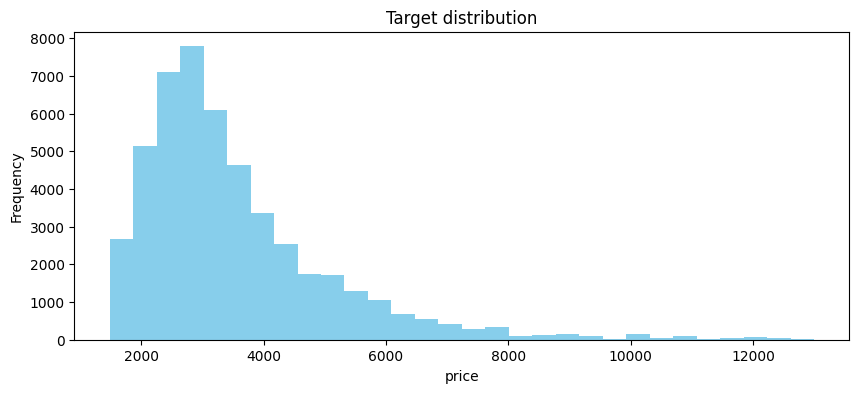

In [291]:
fig = plt.figure(figsize=(10, 4))
y.plot.hist(bins=30, color='skyblue')
plt.title('Target distribution')
plt.xlabel('price')
plt.show()

Из графика видно, что распределение target-а имеет длинный хвост.  
Чтобы избежать ситуации, при которой в некоторых фолдах окажется только недвижимость с низкой или высокой ценой, разделим target на бины и применим StratifiedKFold валидацию, которая включит в каждый фолд недвижимость из всех бинов.

In [292]:
y_binned = pd.qcut(y, q=5, labels=False)
y_binned.name = 'bins'
X_with_bins = pd.concat([X, y_binned], axis=1)
y_binned.value_counts()

bins
2    9952
0    9676
1    9662
4    9591
3    9462
Name: count, dtype: int64

#### 1. CustomStratifiedKFold.

In [293]:
cskf = CustomStratifiedKFold(5)
calculate_train_distribution(cskf, 'CustomStratifiedKFold', X_with_bins, 'bins')

#### 2. StratifiedKFold.

In [294]:
skf = StratifiedKFold(5)
calculate_train_distribution(skf, 'Sklearn StratifiedKFold', X, y_binned)

#### 3. Results.

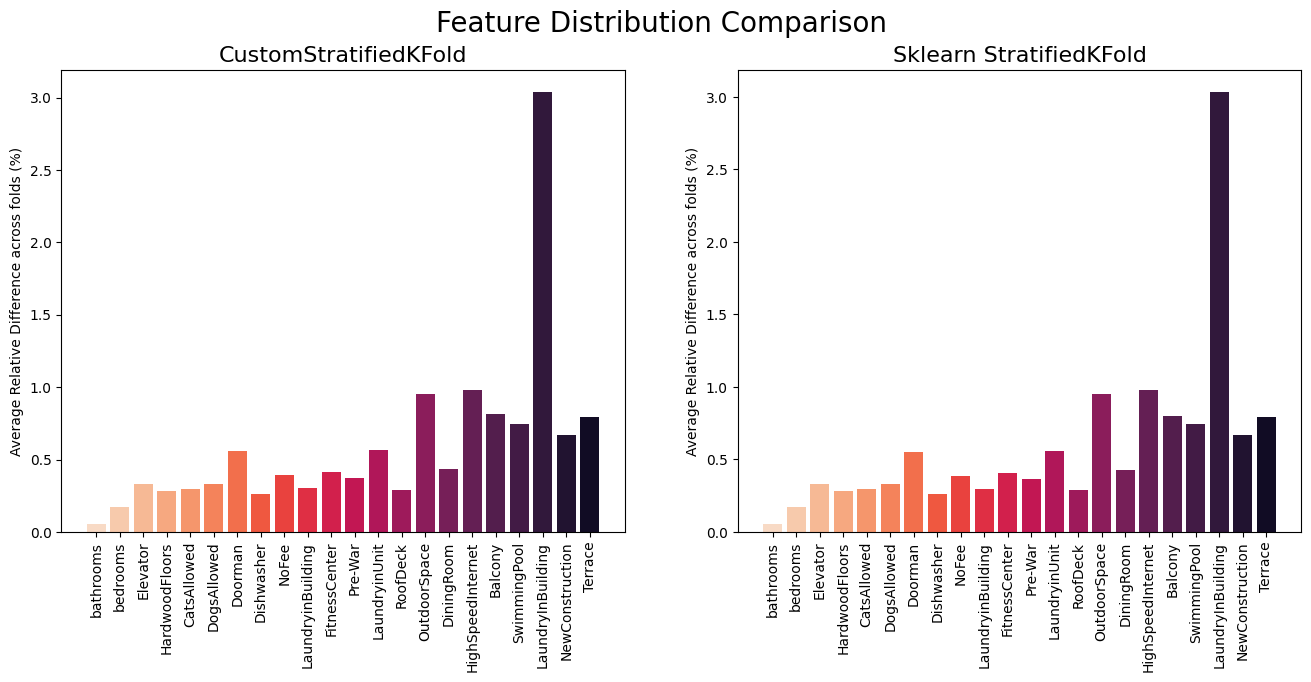

In [295]:
plot_feature_distribution_comparison(start_with=4)

In [296]:
result_target_table.round(2).tail(10)

,count,mean,std,min,25%,50%,75%,max,median
CustomStratifiedKFold fold-0,38671.0,3533.45,1586.59,1485.0,2500.0,3150.0,4052.00,12995.0,3150.0
CustomStratifiedKFold fold-1,38673.0,3532.05,1578.56,1485.0,2500.0,3150.0,4075.00,12995.0,3150.0
CustomStratifiedKFold fold-2,38676.0,3535.09,1587.34,1495.0,2500.0,3150.0,4060.00,12995.0,3150.0
CustomStratifiedKFold fold-3,38676.0,3539.91,1593.15,1485.0,2500.0,3150.0,4065.00,12995.0,3150.0
CustomStratifiedKFold fold-4,38676.0,3535.33,1582.45,1485.0,2500.0,3150.0,4057.00,12995.0,3150.0
Sklearn StratifiedKFold fold-0,38674.0,3533.47,1586.56,1485.0,2500.0,3150.0,4054.00,12995.0,3150.0
Sklearn StratifiedKFold fold-1,38674.0,3532.01,1578.53,1485.0,2500.0,3150.0,4074.25,12995.0,3150.0
Sklearn StratifiedKFold fold-2,38674.0,3535.13,1587.37,1495.0,2500.0,3150.0,4060.00,12995.0,3150.0
Sklearn StratifiedKFold fold-3,38675.0,3539.89,1593.17,1485.0,2500.0,3150.0,4065.00,12995.0,3150.0
Sklearn StratifiedKFold fold-4,38675.0,3535.35,1582.47,1485.0,2500.0,3150.0,4057.00,12995.0,3150.0


`Conclusion`: CustomStratifiedKFold() работает почти так же, как и StratifiedKFold() из Sklearn. 

### 4. Time series split.

#### 1. CustomTimeSeriesSplit.

In [297]:
ctss = CustomTimeSeriesSplit(5)
calculate_train_distribution(ctss, 'CustomTimeSeriesSplit', X_with_time, 'created')

#### 2. TimeSeriesSplit.

In [298]:
tss = TimeSeriesSplit(5)
calculate_train_distribution(tss, 'Sklearn TimeSeriesSplit', X_with_time.sort_values(by='created'))

#### 3. Results.

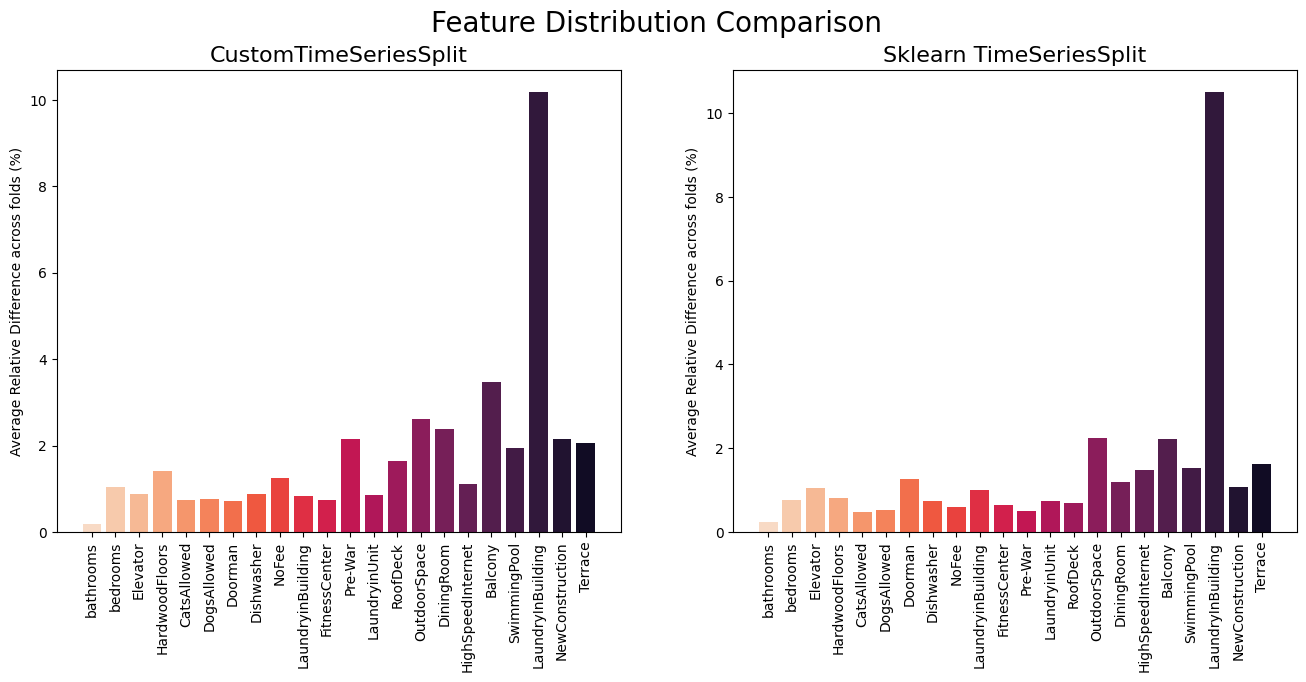

In [299]:
plot_feature_distribution_comparison(start_with=6)

In [300]:
result_target_table.round(2).tail(10)

,count,mean,std,min,25%,50%,75%,max,median
CustomTimeSeriesSplit fold-0,8058.0,3467.67,1551.05,1495.0,2475.0,3095.0,3995.0,12995.0,3095.0
CustomTimeSeriesSplit fold-1,16115.0,3504.83,1567.87,1495.0,2500.0,3100.0,4000.0,12995.0,3100.0
CustomTimeSeriesSplit fold-2,24172.0,3509.76,1566.65,1495.0,2499.0,3100.0,4000.0,12995.0,3100.0
CustomTimeSeriesSplit fold-3,32229.0,3532.61,1589.38,1485.0,2500.0,3150.0,4065.0,12995.0,3150.0
CustomTimeSeriesSplit fold-4,40286.0,3532.29,1587.95,1485.0,2500.0,3150.0,4062.0,12995.0,3150.0
Sklearn TimeSeriesSplit fold-0,8058.0,3531.31,1567.71,1495.0,2500.0,3150.0,4050.0,12900.0,3150.0
Sklearn TimeSeriesSplit fold-1,16115.0,3542.36,1584.13,1495.0,2500.0,3150.0,4050.0,12995.0,3150.0
Sklearn TimeSeriesSplit fold-2,24172.0,3551.96,1596.52,1495.0,2500.0,3175.0,4095.0,12995.0,3175.0
Sklearn TimeSeriesSplit fold-3,32229.0,3550.90,1595.28,1485.0,2500.0,3176.0,4095.0,12995.0,3176.0
Sklearn TimeSeriesSplit fold-4,40286.0,3540.34,1584.84,1485.0,2500.0,3150.0,4095.0,12995.0,3150.0


`Conclusion`: CustomTimeSeriesSplit() немного отличается от своей Sklearn версии — как по распределению target-а, так и признаков.

### 5. Results.

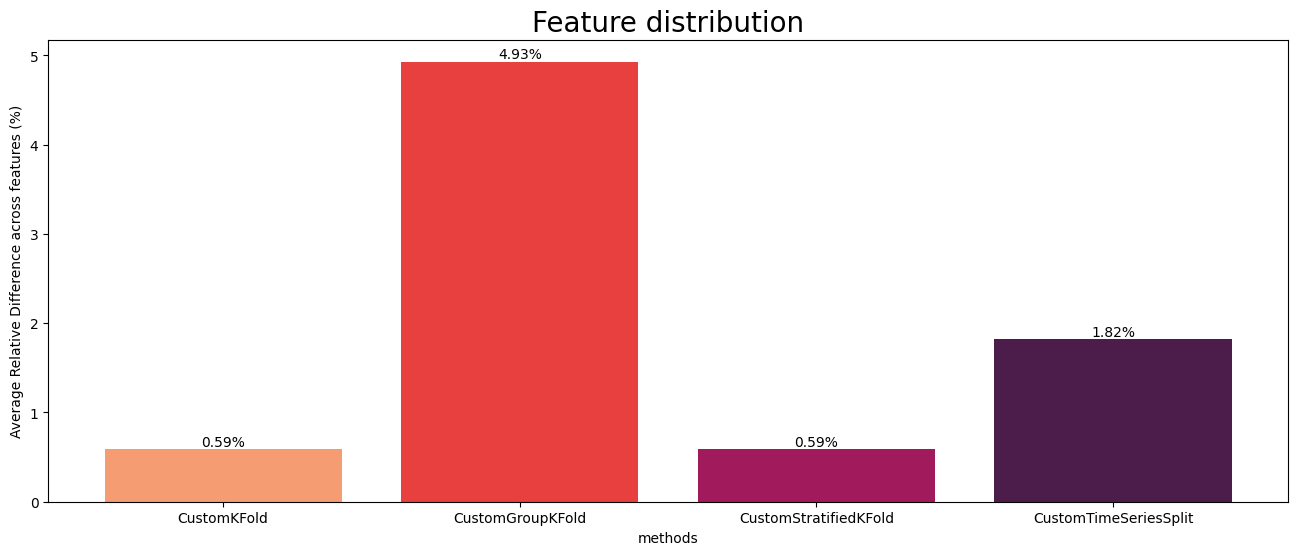

In [301]:
methods = ['CustomKFold', 'CustomGroupKFold', 'CustomStratifiedKFold', 'CustomTimeSeriesSplit']
avg_rel_diff = result_feature_table.mean(axis=1).round(2)[methods]

fig = plt.figure(figsize=(16, 6))
bar_plot = plt.bar(x=avg_rel_diff.index,
                   height=avg_rel_diff.values,
                   color=sns.color_palette('rocket_r', 4))
plt.title('Feature distribution', fontsize=20)
plt.xlabel('methods'), plt.ylabel('Average Relative Difference across features (%)')
plt.bar_label(bar_plot, fmt='%.2f%%')
plt.show()

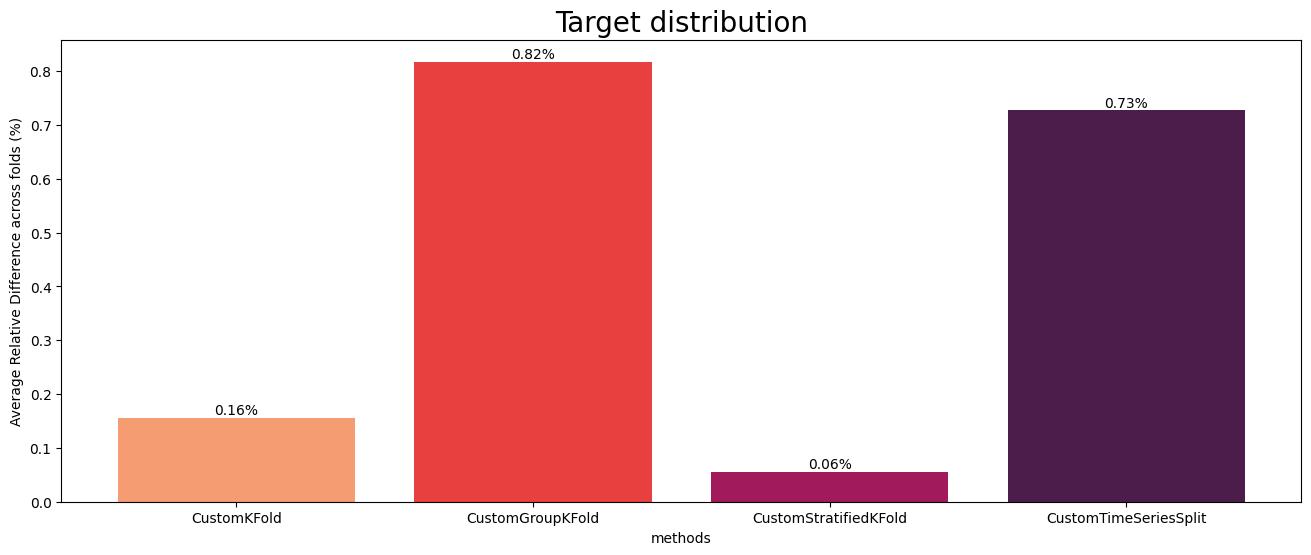

In [302]:
avg_real_diff = {}
mean_original = y.mean()

for method in methods:
    rel_diff = []
    means_method = result_target_table.loc[result_target_table.index.str.startswith(method)]['mean']
    for mean_method in means_method:
        rel_diff.append(100 * abs(mean_original - mean_method) / abs(mean_original))
    avg_real_diff[method] = np.mean(rel_diff)

fig = plt.figure(figsize=(16, 6))
bar_plot = plt.bar(x=avg_real_diff.keys(), 
                   height=avg_real_diff.values(),
                   color=sns.color_palette('rocket_r', 4))
plt.title('Target distribution', fontsize=20)
plt.xlabel('methods'), plt.ylabel('Average Relative Difference across folds (%)')
plt.bar_label(bar_plot, fmt='%.2f%%')
plt.show()

`Hypothesis`: **CustomKFold** и **CustomStratifiedKFold** имеют наименьший сдвиг распределения признаков относительно исходного датасета. Ближе всего к оригинальному распределению target-а оказалась **CustomStratifiedKFold** валидация: 0.06%, что в 2.67 раз меньше, чем у CustomKFold. Скорее всего, **CustomStratifiedKFold** покажет наилучшие результаты при обучении моделей.

Обучим Lasso на наших схемах.

In [303]:
result_MAE = pd.DataFrame(columns=['train', 'test'])
result_RMSE = result_MAE.copy()
result_R2 = result_RMSE.copy()

def calculate_metrics(selector, selector_name, *split_args):
    reg = Lasso()
    mae_train, mae_test = [], []
    rmse_train, rmse_test = [], []
    r2_train, r2_test = [], []
    
    for train_index, test_index in selector.split(*split_args):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)

        mae_train.append(mean_absolute_error(y_train, y_pred_train))
        mae_test.append(mean_absolute_error(y_test, y_pred_test))
        
        rmse_train.append(root_mean_squared_error(y_train, y_pred_train))
        rmse_test.append(root_mean_squared_error(y_test, y_pred_test))

        r2_train.append(r2_score(y_train, y_pred_train))
        r2_test.append(r2_score(y_test, y_pred_test))

    result_MAE.loc[selector_name] = [np.mean(mae_train), np.mean(mae_test)]
    result_RMSE.loc[selector_name] = [np.mean(rmse_train), np.mean(rmse_test)]
    result_R2.loc[selector_name] = [np.mean(r2_train), np.mean(r2_test)]

In [304]:
calculate_metrics(ckf, 'CustomKFold', X)
calculate_metrics(cgkf, 'CustomGroupKFold', X_with_id, 'building_id')
calculate_metrics(cskf, 'CustomStratifiedKFold', X_with_bins, 'bins')
calculate_metrics(ctss, 'CustomTimeSeriesSplit', X_with_time, 'created')

In [305]:
print('MAE')
display(result_MAE.round(2))
print('RMSE')
display(result_RMSE.round(2))
print('R2')
display(result_R2.round(2))

MAE


,train,test
CustomKFold,708.34,708.93
CustomGroupKFold,708.07,712.25
CustomStratifiedKFold,708.35,708.89
CustomTimeSeriesSplit,702.16,708.10


RMSE


,train,test
CustomKFold,1027.34,1027.90
CustomGroupKFold,1026.93,1031.01
CustomStratifiedKFold,1027.33,1027.64
CustomTimeSeriesSplit,1031.95,1026.45


R2


,train,test
CustomKFold,0.58,0.58
CustomGroupKFold,0.58,0.57
CustomStratifiedKFold,0.58,0.58
CustomTimeSeriesSplit,0.57,0.58


`Conclusion`: Лучше всего себя показали CustomStratifiedKFold и CustomKFold кросс-валидации.

## 5. Feature Selection.

Нормализуем данные и разделим на обучающую, валидационную и тестовую выборки.

In [306]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

splitter = DataSplitter(random_state=21)
X_train, X_valid, X_test, \
y_train, y_valid, y_test = splitter.train_valid_test_split(X_scaled, y, validation_size=0.2, test_size=0.2)

Подберём лучший гиперпараметр alpha.

In [307]:
alphas = [0.001, 0.01, 0.1, 1, 10]
for alpha in alphas:
    reg = Lasso(alpha=alpha)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_valid)
    print(f'R2 alpha={alpha}: {np.round(r2_score(y_valid, y_pred), 6)}')

R2 alpha=0.001: 0.572162
R2 alpha=0.01: 0.572162
R2 alpha=0.1: 0.572167
R2 alpha=1: 0.572197
R2 alpha=10: 0.571787


Таким образом, лучший гиперпараметр **alpha** для Lasso при нормализованных данных **= 1**.

Обучим линейную модель Lasso.

In [308]:
result_table = pd.DataFrame(columns=['MAE', 'RMSE', 'R2', 'Time'])

def calculate_quality(selector, y_test, y_pred, time):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    result_table.loc[selector] = [mae, rmse, r2, time]
    return result_table.round(2)

In [309]:
start = time.time()

reg = Lasso(random_state=21)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

end = time.time()

calculate_quality('The original dataset', y_test, y_pred, end - start)

,MAE,RMSE,R2,Time
The original dataset,714.56,1028.78,0.58,0.7


### 1. Top 10 features selected by weight coefficients. 

In [310]:
def get_top_weight_coefs(X_train, y_train):
    reg.fit(X_train, y_train)

    features_coefs = pd.Series(reg.coef_, index=X_train.columns)
    top_coefs = features_coefs.sort_values(ascending=False, key=abs)[:10]
    return top_coefs

In [311]:
start = time.time()

top_weight_features = get_top_weight_coefs(X_train, y_train).index

reg.fit(X_train[top_weight_features], y_train)
y_pred = reg.predict(X_test[top_weight_features])

end = time.time()

calculate_quality('By weight', y_test, y_pred, end - start)

,MAE,RMSE,R2,Time
The original dataset,714.56,1028.78,0.58,0.7
By weight,718.85,1034.15,0.57,1.0


`Conclusion`: После удаления признаков качество модели в среднем ухудшилось.

### 2. Simple feature selection by nan-ratio in feature and correlation.

In [312]:
def get_top_corr_features(X_train, y_train):
    nan_ratio = X_train.isna().mean()
    corr = X_train.corrwith(y_train).abs()
    scores = corr * (1 - nan_ratio)
    top_scores = scores.sort_values(ascending=False)[:10]
    return top_scores

In [313]:
start = time.time()

top_corr_features = get_top_corr_features(X_train, y_train).index

reg.fit(X_train[top_corr_features], y_train)
y_pred = reg.predict(X_test[top_corr_features])

end = time.time()

calculate_quality('By nan-ratio and correlation', y_test, y_pred, end - start)

,MAE,RMSE,R2,Time
The original dataset,714.56,1028.78,0.58,0.70
By weight,718.85,1034.15,0.57,1.00
By nan-ratio and correlation,730.34,1046.34,0.56,0.11


`Conclusion`: Простой отбор признаков по nan-ratio и корреляции показал более низкое качество по сравнению с отбором признаков по весовым коэффициентам.

### 3. Feature selection using shap values.

Shap values показывают вклад признаков в предсказание модели:
$$
prediction = mean + \sum_{i=1}^{N} \phi_i
$$
где:  
- $mean$ — среднее предсказание модели  
- $\phi_i$ — вклад i-го признака в прогноз
- $N$ — количество признаков  

Более высокое среднее абсолютное значение shap для признака означает, что данный признак вносит больший вклад в предсказание модели.

In [314]:
def get_top_shap_features(X_train, y_train):
    reg.fit(X_train, y_train)

    explainer = shap.LinearExplainer(reg, X_train)
    importance_table = pd.DataFrame(explainer(X_train).values, columns=X_train.columns).abs()
    importance_table = importance_table.mean().sort_values(ascending=False)[:10]
    return importance_table

In [315]:
start = time.time()

top_shap_features = get_top_shap_features(X_train, y_train).index

reg.fit(X_train[top_shap_features], y_train)
y_pred = reg.predict(X_test[top_shap_features])

end = time.time()

calculate_quality('By shap', y_test, y_pred, end - start)

,MAE,RMSE,R2,Time
The original dataset,714.56,1028.78,0.58,0.70
By weight,718.85,1034.15,0.57,1.00
By nan-ratio and correlation,730.34,1046.34,0.56,0.11
By shap,718.85,1034.15,0.57,1.54


`Conclusion`: Лучшие метрики имеет оригинальный датасет со всеми признаками. Самым быстрым методом отбора признаков оказался по nan-ration и корреляции.

### 4. Compare stability.

Проверим стабильность каждого метода отбора признаков.

In [316]:
feature_selections = {'top_weight_coefs': get_top_weight_coefs, 
                      'top_corr_features': get_top_corr_features, 
                      'top_shap_features': get_top_shap_features}

def check_stability(selector_name, selector):
    top_features = pd.DataFrame(columns=X.columns)
    
    for i, (train_index, test_index) in enumerate(cskf.split(X_with_bins, 'bins')):
        X_train , y_train = X_scaled.loc[train_index], y.loc[train_index]
        top_features.loc[i] = selector(X_train, y_train)

    top_features = top_features.fillna(0)
    top_features = pd.DataFrame({'mean': top_features.mean(), 
                                 'std': top_features.std()})
    top_features = top_features.sort_values(by='mean', ascending=False, key=abs)[:10]
    top_features['std/mean'] = abs(top_features['std'] / top_features['mean'])
    print(selector_name)
    print(f'Average std/mean across features: {top_features['std/mean'].mean().round(2)}')
    display(top_features.round(2))

In [317]:
for selector_name, selector in feature_selections.items():
    check_stability(selector_name, selector)

top_weight_coefs
Average std/mean across features: 0.03


,mean,std,std/mean
bathrooms,710.36,7.52,0.01
bedrooms,510.06,2.24,0.00
Doorman,303.43,2.20,0.01
LaundryinUnit,170.87,3.61,0.02
Elevator,112.16,2.57,0.02
FitnessCenter,106.25,5.33,0.05
LaundryinBuilding,-101.59,4.75,0.05
HardwoodFloors,-83.14,5.70,0.07
LaundryInBuilding,-79.51,1.48,0.02
NoFee,-77.71,2.30,0.03


top_corr_features
Average std/mean across features: 0.1


,mean,std,std/mean
bathrooms,0.67,0.00,0.01
bedrooms,0.55,0.00,0.00
Doorman,0.28,0.00,0.01
LaundryinUnit,0.26,0.00,0.01
FitnessCenter,0.23,0.00,0.01
Dishwasher,0.23,0.00,0.01
DiningRoom,0.22,0.00,0.01
Elevator,0.22,0.00,0.01
OutdoorSpace,0.15,0.00,0.01
LaundryinBuilding,0.08,0.08,0.91


top_shap_features
Average std/mean across features: 0.05


,mean,std,std/mean
bathrooms,502.34,28.36,0.06
bedrooms,429.19,1.33,0.00
Doorman,297.46,2.23,0.01
LaundryinUnit,130.27,20.55,0.16
Elevator,112.38,2.93,0.03
LaundryinBuilding,95.44,6.01,0.06
FitnessCenter,92.42,7.90,0.09
HardwoodFloors,82.82,5.31,0.06
NoFee,74.90,1.65,0.02
Dishwasher,70.37,2.45,0.03


`Conclusion`: Самый стабильный метод отбора признаков - по весам.

## 6. Hyperparameter optimization.

### 1. Implement GridSearchCV for sklearn's ElasticNet model.

In [318]:
class CustomGridSearchCV():
    def __init__(self, param_grid, random_state=None, cv=5):
        self.__alpha = param_grid['alpha']
        self.__l1_ratio = param_grid['l1_ratio']
        self.__random_state = random_state
        self.__cv = cv

    def fit(self, X, y):
        self.cv_results_ = {'alpha': [], 'l1_ratio': [], 'mean_scores': []}
        kf = CustomKFold(self.__cv)
        for alpha in self.__alpha:
            for l1_ratio in self.__l1_ratio:
                scores = []
                self.cv_results_['alpha'].append(alpha)
                self.cv_results_['l1_ratio'].append(l1_ratio)

                elastic_net = ElasticNet(alpha=alpha, 
                                         l1_ratio=l1_ratio,
                                         random_state=self.__random_state)

                for train_index, test_index in kf.split(X):
                    X_train, X_test = X.loc[train_index], X.loc[test_index]
                    y_train, y_test = y.loc[train_index], y.loc[test_index]

                    elastic_net.fit(X_train, y_train)
                    y_pred = elastic_net.predict(X_test)
                    r2 = r2_score(y_test, y_pred)
                    scores.append(r2)
                    
                self.cv_results_['mean_scores'].append(np.mean(scores))

        self.best_score_ = np.max(self.cv_results_['mean_scores'])
        best_id = np.argmax(self.cv_results_['mean_scores'])
        self.best_params_ = {'alpha': self.cv_results_['alpha'][best_id],
                             'l1_ratio': self.cv_results_['l1_ratio'][best_id]}

### 2. Implement RandomizedSearchCV for sklearn's ElasticNet model.

In [319]:
class CustomRandomizedSearchCV():
    def __init__(self, param_distributions, random_state=None, n_iter=10, cv=5):
        self.__alpha = param_distributions['alpha']
        self.__l1_ratio = param_distributions['l1_ratio']
        self.__random_state = random_state
        self.__n_iter = n_iter
        self.__cv = cv

    def fit(self, X, y):
        self.cv_results_ = {'alpha': [], 'l1_ratio': [], 'mean_scores': []}
        kf = CustomKFold(self.__cv)
        for _ in range(self.__n_iter):
            scores = []
            alpha = self.__alpha.rvs(random_state=self.__random_state)
            l1_ratio = self.__l1_ratio.rvs(random_state=self.__random_state)
            self.cv_results_['alpha'].append(alpha)
            self.cv_results_['l1_ratio'].append(l1_ratio)

            elastic_net = ElasticNet(alpha=alpha, 
                                     l1_ratio=l1_ratio, 
                                     random_state=self.__random_state)

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]

                elastic_net.fit(X_train, y_train)
                y_pred = elastic_net.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                scores.append(r2)
            
            self.cv_results_['mean_scores'].append(np.mean(scores))

        self.best_score_ = np.max(self.cv_results_['mean_scores'])
        best_id = np.argmax(self.cv_results_['mean_scores'])
        self.best_params_ = {'alpha': self.cv_results_['alpha'][best_id],
                             'l1_ratio': self.cv_results_['l1_ratio'][best_id]}

### 3. Find the best combination of model hyperparameters.

In [320]:
result_table = pd.DataFrame(columns=['MAE', 'RMSE', 'R2'])

def calculate_elastic_net_metrics(type_optimization, alpha, l1_ratio):
    elastic_net = ElasticNet(alpha=alpha, 
                             l1_ratio=l1_ratio, 
                             random_state=21)
    elastic_net.fit(X_train, y_train)
    y_pred = elastic_net.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    result_table.loc[type_optimization] = [mae, rmse, r2]
    return result_table.round(2)

In [321]:
cgs = CustomGridSearchCV(param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2],
                                     'l1_ratio': [0.001, 0.01, 0.1, 1]},
                         random_state=21)
cgs.fit(X_scaled, y)
print(f'Best score: {cgs.best_score_}')
print(f'Best params:')
print(cgs.best_params_)

Best score: 0.5791726180235296
Best params:
{'alpha': 0.001, 'l1_ratio': 0.001}


In [322]:
calculate_elastic_net_metrics('CustomGridSearchCV', 
                              alpha=cgs.best_params_['alpha'], 
                              l1_ratio=cgs.best_params_['l1_ratio'])

,MAE,RMSE,R2
CustomGridSearchCV,714.73,1028.91,0.58


In [323]:
crs = CustomRandomizedSearchCV(param_distributions={'alpha': uniform(0, 2), 
                                                    'l1_ratio': uniform(0, 1)}, 
                               random_state=21)
crs.fit(X_scaled, y)
print(f'Best score: {crs.best_score_}')
print(f'Best params:')
print(crs.best_params_)

Best score: 0.576926314562189
Best params:
{'alpha': np.float64(0.09744976161825458), 'l1_ratio': np.float64(0.04872488080912729)}


In [324]:
calculate_elastic_net_metrics('CustomRandomizedSearchCV', 
                              alpha=crs.best_params_['alpha'], 
                              l1_ratio=crs.best_params_['l1_ratio'])

,MAE,RMSE,R2
CustomGridSearchCV,714.73,1028.91,0.58
CustomRandomizedSearchCV,715.02,1031.47,0.57


`Conclusion`: CustomGridSearchCV показал себя лучше, чем CustomRandomizedSearchCV.

### 4. Try optuna.

In [325]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 2)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net.fit(X_train, y_train)
    y_pred = elastic_net.predict(X_valid)
    score = r2_score(y_valid, y_pred)
    return score

In [326]:
sampler = optuna.samplers.TPESampler(seed=21)

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2026-03-01 00:43:23,598] A new study created in memory with name: no-name-9bed7899-038c-4cdf-9db9-eae446734a35
[I 2026-03-01 00:43:24,246] Trial 0 finished with value: 0.5714763344674403 and parameters: {'alpha': 0.09744976161825458, 'l1_ratio': 0.28910965978981684}. Best is trial 0 with value: 0.5714763344674403.
[I 2026-03-01 00:43:24,440] Trial 1 finished with value: 0.4502458027287827 and parameters: {'alpha': 1.4419326936624597, 'l1_ratio': 0.021616249915949792}. Best is trial 0 with value: 0.5714763344674403.
[I 2026-03-01 00:43:24,713] Trial 2 finished with value: 0.5489820416975415 and parameters: {'alpha': 0.41184553053487805, 'l1_ratio': 0.0507732566953768}. Best is trial 0 with value: 0.5714763344674403.
[I 2026-03-01 00:43:24,967] Trial 3 finished with value: 0.5646194225197629 and parameters: {'alpha': 0.6045437879292337, 'l1_ratio': 0.6639102946247}. Best is trial 0 with value: 0.5714763344674403.
[I 2026-03-01 00:43:25,226] Trial 4 finished with value: 0.5606483491303

In [327]:
print(f'Best score: {study.best_value}')
print(f'Best params:')
print(study.best_params)

Best score: 0.5722438358188143
Best params:
{'alpha': 0.1391419092252011, 'l1_ratio': 0.8674044839930883}


In [328]:
calculate_elastic_net_metrics('Optuna',
                              alpha=study.best_params['alpha'], 
                              l1_ratio=study.best_params['l1_ratio'])

,MAE,RMSE,R2
CustomGridSearchCV,714.73,1028.91,0.58
CustomRandomizedSearchCV,715.02,1031.47,0.57
Optuna,714.38,1028.98,0.58


### 5. Run optuna using the CustomStratifiedKFold cross-validation scheme.

In [329]:
def objective_with_validation(trial):
    alpha = trial.suggest_float('alpha', 0, 2)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    scores = []
    
    cskf = CustomStratifiedKFold(5)
    for train_index, test_index in cskf.split(X_with_bins, 'bins'):
        elastic_net.fit(X_scaled.loc[train_index], y.loc[train_index])
        y_pred = elastic_net.predict(X_scaled.loc[test_index])
        scores += [r2_score(y.loc[test_index], y_pred)]
    return np.mean(scores)

In [330]:
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_with_validation, n_trials=10)

[I 2026-03-01 00:43:27,571] A new study created in memory with name: no-name-804360a9-e635-4bf4-b974-522a1d69171b
[I 2026-03-01 00:43:29,069] Trial 0 finished with value: 0.5679848285630567 and parameters: {'alpha': 0.8174366588874651, 'l1_ratio': 0.7133604278844787}. Best is trial 0 with value: 0.5679848285630567.
[I 2026-03-01 00:43:30,899] Trial 1 finished with value: 0.577974315698903 and parameters: {'alpha': 0.5413395453462675, 'l1_ratio': 0.854102871991344}. Best is trial 1 with value: 0.577974315698903.
[I 2026-03-01 00:43:32,179] Trial 2 finished with value: 0.5486023905785391 and parameters: {'alpha': 1.8263279392236111, 'l1_ratio': 0.7607560696646062}. Best is trial 1 with value: 0.577974315698903.
[I 2026-03-01 00:43:33,382] Trial 3 finished with value: 0.5046917937904156 and parameters: {'alpha': 1.0333370755161324, 'l1_ratio': 0.16783576522150734}. Best is trial 1 with value: 0.577974315698903.
[I 2026-03-01 00:43:34,872] Trial 4 finished with value: 0.5500186418303059 an

In [331]:
calculate_elastic_net_metrics('Optuna with cross-validation', 
                              alpha=study.best_params['alpha'], 
                              l1_ratio=study.best_params['l1_ratio'])

,MAE,RMSE,R2
CustomGridSearchCV,714.73,1028.91,0.58
CustomRandomizedSearchCV,715.02,1031.47,0.57
Optuna,714.38,1028.98,0.58
Optuna with cross-validation,714.68,1030.82,0.57


`Conclusion`: в среднем лучше всего себя показали **CustomGridSearchCV** и **Optuna**. Однако Optuna гораздо быстрее подбирает гиперпараметры, чем CustomGridSearchCV.